In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from model import *
from model_burger_pinn import *

import scipy.io # To load the matrix
from pyDOE import lhs # For Latin Hypercube samplig method
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

import glob

In [80]:
nu = 0.01/np.pi
noise = 0.0        

data = scipy.io.loadmat('burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None] 

In [81]:
# # # Data driven :

error_data_u = []
n_samples_u = [0,50,100,200,500,1000,2000,5000,10000]#,50,100,200,500,1000,2000,5000,10000]

for N_u in n_samples_u:
    PATH = f'DATA/B_E50000_U{N_u}_F0.pt'

    # Load model
    model_test = Model(in_size=2,neurons_layer=[20,20,20,20,20,20],out_size=1)
    model_test.load_state_dict(torch.load(PATH))
    model_test.eval()

    # Predictions
    net_u = Net_U(model=model_test)

    x = torch.tensor(X_star[:, 0:1], requires_grad=True).float()
    t = torch.tensor(X_star[:, 1:2], requires_grad=True).float()

    u_preds = net_u(x, t)
    u_preds = u_preds.detach().cpu().numpy()

    error_u = np.linalg.norm(u_star-u_preds,2)/np.linalg.norm(u_star,2)
    error_data_u.append(error_u)

In [82]:
# # # PINN :
error_data_f = []

n_samples_f = [0,50,100,200,500,1000,2000,5000,10000]

for N_u in n_samples_f:
    PATH = f'PINN/B_E50000_U{N_u}_F10000.pt'

    # Load model
    model_test = Model(in_size=2,neurons_layer=[20,20,20,20,20,20],out_size=1)
    model_test.load_state_dict(torch.load(PATH))
    model_test.eval()

    # Predictions
    net_u = Net_U(model=model_test)

    x = torch.tensor(X_star[:, 0:1], requires_grad=True).float()
    t = torch.tensor(X_star[:, 1:2], requires_grad=True).float()

    f_preds = net_u(x, t)
    f_preds = f_preds.detach().cpu().numpy()

    error_f = np.linalg.norm(u_star-f_preds,2)/np.linalg.norm(u_star,2)
    error_data_f.append(error_f)

In [83]:
error_data_u

[0.7203316898617697,
 0.12952720314622024,
 0.19597191907912898,
 0.09830231696571949,
 0.0243153011386309,
 0.01799220861924825,
 0.004140919676664426,
 0.002667238005331387,
 0.0014733305882597132]

In [84]:
error_data_f

[0.008847531391692271,
 0.011900957494630503,
 0.003077466939596309,
 0.007552411871431327,
 0.00549444918247695,
 0.010231930922550847,
 0.0061418767109311665,
 0.004715346550043718,
 0.0022189158668541875]

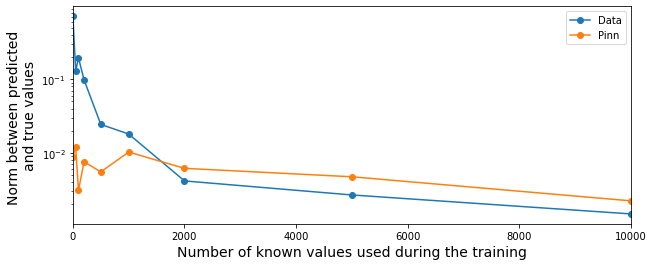

In [86]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(n_samples_u,error_data_u,label='Data',marker='o')
ax.plot(n_samples_f,error_data_f,label='Pinn',marker='o')
ax.set_xlabel('Number of known values used during the training',fontsize=14)
ax.set_ylabel('Norm between predicted \nand true values',fontsize=14)
ax.set_yscale('log')
ax.set_xlim(0,1e4)
plt.legend()
plt.savefig('PINN_DATA_Burgers.png',dpi=300,bbox_inches='tight')

In [87]:
class Net_U(nn.Module):
    def __init__(self,dnn):

        nn.Module.__init__(self)

        self.dnn = dnn

    def forward(self,x,t):
        u = self.dnn(torch.cat([x, t], dim=1))
        return u

In [88]:
# # # Parameters
nu = 0.01/np.pi
noise = 0.0        

N_u = 100
N_f = 10000

data = scipy.io.loadmat('burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0)    

# Initial conditions
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))  # x = -1:1, t = 0
uu1 = Exact[0:1,:].T

# Boundary conditions
xx2 = np.hstack((X[:,0:1], T[:,0:1]))   # x = -1, t = 0:1
uu2 = Exact[:,0:1]

# Boundary conditions
xx3 = np.hstack((X[:,-1:], T[:,-1:])) # x = 1, t = 0:1
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))

print('Collocations :',X_u_train.shape)
print('All residuals :',X_f_train.shape)

Collocations : (100, 2)
All residuals : (10100, 2)


In [89]:
PATH = f'PINN/B_E50000_U0_F10000.pt'

# Load model
model_test = Model(in_size=2,neurons_layer=[20,20,20,20,20,20],out_size=1)
model_test.load_state_dict(torch.load(PATH))
model_test.eval()

Model(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
  )
  (out): Linear(in_features=20, out_features=1, bias=True)
  (tanh): Tanh()
)

In [90]:
# Predictions
net_u = Net_U(dnn=model_test)

x = torch.tensor(X_star[:, 0:1], requires_grad=True).float()
t = torch.tensor(X_star[:, 1:2], requires_grad=True).float()

u_preds = net_u(x, t)

u_preds = u_preds.detach().cpu().numpy()

In [91]:
U_pred = griddata(X_star, u_preds.flatten(), (X, T), method='cubic')
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')
U_error = griddata(X_star, u_star.flatten()-u_preds.flatten(), (X, T), method='cubic')

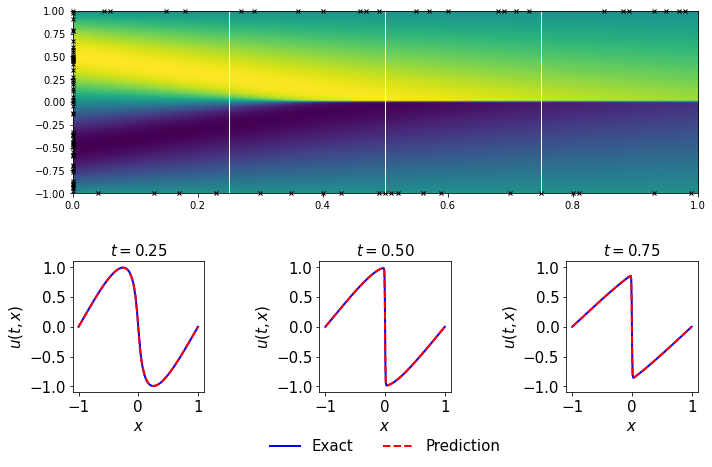

In [92]:
fig = plt.figure(figsize=(10,7))

gs = gridspec.GridSpec(2, 3)

ax = fig.add_subplot(gs[0, :])

h = ax.imshow(U_star.T,extent=[0, 1, -1, 1], aspect='auto',cmap='viridis')
ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,
    clip_on = False
)
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax0 = fig.add_subplot(gs[1, 0])
ax1 = fig.add_subplot(gs[1, 1])
ax2 = fig.add_subplot(gs[1, 2])

ax0.set_title('$t = 0.25$', fontsize = 15)
ax0.plot(data['x'].flatten()[:,None],Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax0.plot(data['x'].flatten()[:,None],U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax0.axis('square')

ax1.set_title('$t = 0.50$', fontsize = 15)
ax1.plot(data['x'].flatten()[:,None],Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax1.plot(data['x'].flatten()[:,None],U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax1.axis('square')

ax2.set_title('$t = 0.75$', fontsize = 15)
ax2.plot(data['x'].flatten()[:,None],Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax2.plot(data['x'].flatten()[:,None],U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax2.axis('square')

line = np.linspace(data['x'].flatten()[:,None].min(), data['x'].flatten()[:,None].max(), 2)[:,None]
ax.plot(data['t'].flatten()[:,None][25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(data['t'].flatten()[:,None][50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(data['t'].flatten()[:,None][75]*np.ones((2,1)), line, 'w-', linewidth = 1)

for ax in [ax0,ax1,ax2]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1]) 

ax1.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.25), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

plt.tight_layout()
plt.savefig('PINN_Burgers_2D.png',dpi=300,bbox_inches='tight')

In [93]:
# # # Parameters
nu = 0.01/np.pi
noise = 0.0        

N_f = 2000

data = scipy.io.loadmat('burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]                 

# Clean Domain
idx = np.random.choice(X_star.shape[0], N_f, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

print('Total training data',X_u_train.shape[0])

Total training data 2000


In [94]:
PATH = f'DATA/B_E50000_U2000_F0.pt'

# Load model
model_test = Model(in_size=2,neurons_layer=[20,20,20,20,20,20],out_size=1)
model_test.load_state_dict(torch.load(PATH))
model_test.eval()

Model(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
  )
  (out): Linear(in_features=20, out_features=1, bias=True)
  (tanh): Tanh()
)

In [95]:
# Predictions
net_u = Net_U(dnn=model_test)

x = torch.tensor(X_star[:, 0:1], requires_grad=True).float()
t = torch.tensor(X_star[:, 1:2], requires_grad=True).float()

u_preds = net_u(x, t)

u_preds = u_preds.detach().cpu().numpy()

In [96]:
U_pred = griddata(X_star, u_preds.flatten(), (X, T), method='cubic')
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')
U_error = griddata(X_star, u_star.flatten()-u_preds.flatten(), (X, T), method='cubic')

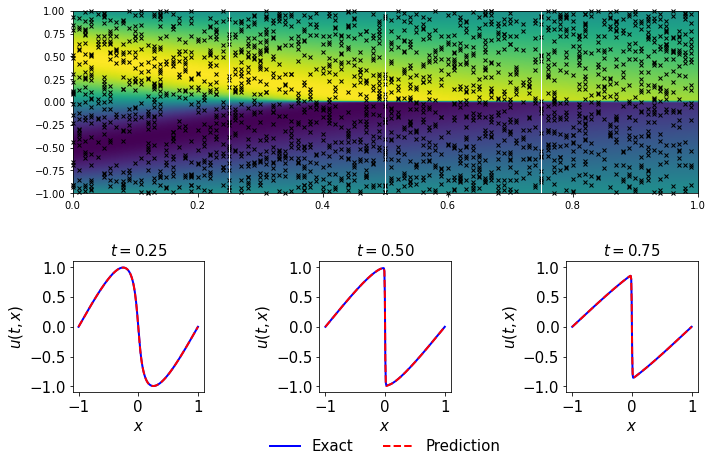

In [97]:
fig = plt.figure(figsize=(10,7))

gs = gridspec.GridSpec(2, 3)

ax = fig.add_subplot(gs[0, :])

h = ax.imshow(U_pred.T,extent=[0, 1, -1, 1], aspect='auto',cmap='viridis')
ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,
    clip_on = False
)
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax0 = fig.add_subplot(gs[1, 0])
ax1 = fig.add_subplot(gs[1, 1])
ax2 = fig.add_subplot(gs[1, 2])

ax0.set_title('$t = 0.25$', fontsize = 15)
ax0.plot(data['x'].flatten()[:,None],Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax0.plot(data['x'].flatten()[:,None],U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax0.axis('square')

ax1.set_title('$t = 0.50$', fontsize = 15)
ax1.plot(data['x'].flatten()[:,None],Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax1.plot(data['x'].flatten()[:,None],U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax1.axis('square')

ax2.set_title('$t = 0.75$', fontsize = 15)
ax2.plot(data['x'].flatten()[:,None],Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax2.plot(data['x'].flatten()[:,None],U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax2.axis('square')

line = np.linspace(data['x'].flatten()[:,None].min(), data['x'].flatten()[:,None].max(), 2)[:,None]
ax.plot(data['t'].flatten()[:,None][25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(data['t'].flatten()[:,None][50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(data['t'].flatten()[:,None][75]*np.ones((2,1)), line, 'w-', linewidth = 1)

for ax in [ax0,ax1,ax2]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1]) 

ax1.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.25), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

plt.tight_layout()
plt.savefig('DATA_Burgers_2D.png',dpi=300,bbox_inches='tight')